In [350]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import copy

In [351]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [352]:
def get_data():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    training_data = torchvision.datasets.CIFAR10(root = 'data',
                                               train = True,
                                               transform = transform,
                                               download = True)

    testing_data = torchvision.datasets.CIFAR10(root = 'data',
                                              train = False,
                                              transform = transform,
                                              download=True)
    
    return training_data, testing_data

def get_loaders(training_data, testing_data, batch_size):
    training_loader = torch.utils.data.DataLoader(dataset = training_data,
                                                  batch_size = batch_size,
                                                  shuffle = True)

    testing_loader = torch.utils.data.DataLoader(dataset = testing_data,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    return training_loader, testing_loader

def displayImages(images, labels, classes):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 3, 3
    for i in range(1, (cols * rows) + 1):
        figure.add_subplot(rows, cols, i)
        npimg = images[i-1].numpy()
        plt.axis("off")
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(classes[labels[i-1]])
    plt.show()

In [353]:
def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(training_loader):
        # TODO: remove this, just here to cut down on running time
        if(i == 100):
            break
        print("Training i:" + str(i))
        data, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/(10*100)
    #loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/ (10*100)
    #accuracy = num_correct/len(training_loader.dataset)
    print(f'Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}')
    
    return loss, accuracy

def test(model, testing_loader, criterion):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(testing_loader):
        # TODO: remove this, just here to cut down on running time
        if(i == 10):
            break
        print("Testing i:" + str(i))
        data, labels = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, labels)
        
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
    
    loss = running_loss/(10*10)
    #loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/(10*10)
    #accuracy = num_correct/len(testing_loader.dataset)
    print(f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}')
    
    return loss, accuracy

In [354]:
def get_weights(model):
    return [param.data for param in model.parameters()]

def get_random_directions(weights):
    return [torch.randn(w.size()) for w in weights]

def normalize_directions(directions, weights):
    for d, w in zip(directions, weights):
        d.mul_(w.norm()/(d.norm() + 1e-10))

In [355]:
training_data, testing_data = get_data()
training_loader, testing_loader = get_loaders(training_data, testing_data, 10)
classes = training_data.classes

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


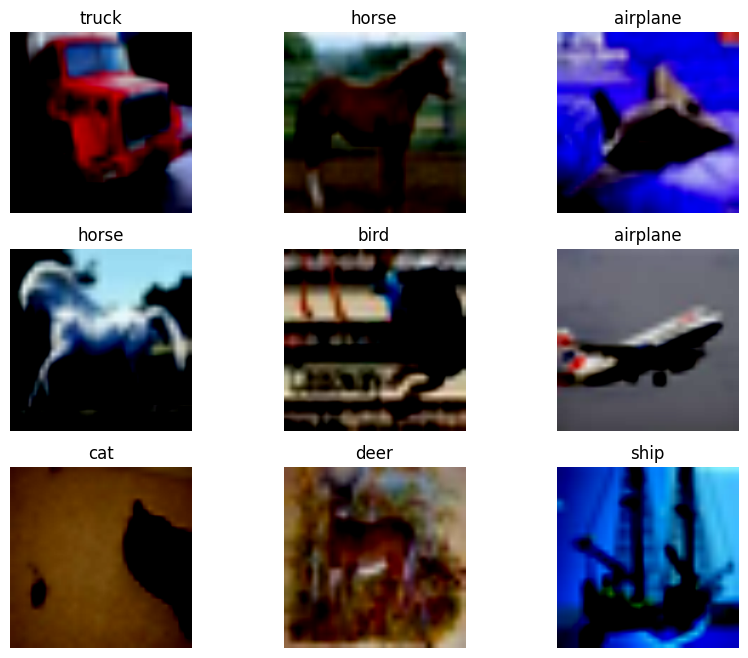

In [356]:
images, labels = next(iter(training_loader))
displayImages(images, labels, classes)

In [357]:
vgg11 = models.vgg11(weights = VGG11_Weights)
vgg11.to(device)

# change the number of classes 
vgg11.classifier[6].out_features = 10

# freeze convolution weights
for param in vgg11.features.parameters():
    param.requires_grad = False
    
optimizer = optim.SGD(vgg11.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [358]:
training_historical_loss, training_historical_accuracy = [], []
testing_historical_loss, testing_historical_accuracy = [], []
for epoch in range(3):
    print("epoch: " + str(epoch))
    training_loss, training_accuracy = train(vgg11, training_loader, criterion, optimizer)
    testing_loss, testing_accuracy = test(vgg11, testing_loader, criterion)
    training_historical_loss.append(training_loss)
    training_historical_accuracy.append(training_accuracy)
    testing_historical_loss.append(testing_loss)
    testing_historical_loss.append(testing_accuracy)

epoch: 0
Training i:0
Training i:1


KeyboardInterrupt: 

In [359]:
# TODO: Organize the above code, just wanted to get a proof of concept

In [360]:
weights = get_weights(vgg11)
random_x_directions = get_random_directions(weights);
random_y_directions = get_random_directions(weights);
normalize_directions(random_x_directions, weights);
normalize_directions(random_y_directions, weights);

In [362]:
x_coordinates = np.linspace(-5, 5, 10)   
y_coordinates = np.linspace(-5, 5, 10)  
X, Y = np.meshgrid(x_coordinates, y_coordinates)

for x in range(-10, 10):
    for y in range(-10, 10):
        
        updated_x_directions = [direction * x for direction in random_x_directions]
        updated_y_directions = [direction * y for direction in random_y_directions]
        delta = [sum(direction) for direction in zip(updated_x_directions, updated_y_directions)]
        old_weights = copy.deepcopy(get_weights(vgg11))
        
        for (p, w, d) in zip(vgg11.parameters(), old_weights, delta):
            p.data = w + torch.Tensor(d).type(type(w))
            
        testing_loss, testing_accuracy = test(vgg11, testing_loader, criterion)
        
        for (p, w) in zip(vgg11.parameters(), old_weights):
            p.data = w

Testing i:0


KeyboardInterrupt: 